# 遺伝的アルゴリズムの実装サンプル

## 1. 遺伝的アルゴリズムとは

データ（解の候補）を遺伝子で表現した個体を複数用意し，<br>
適応度の高い個体を優先的に選択して交叉（組み換え）・突然変異などの操作を繰り返しながら<br>
解を探索する手法．

ダーウィンの理論にヒントを得た，適用分野を限定しない探索技術であり，<br>
ある有利な特徴を持つ個体は，より長く生き延びることが可能で，<br>
その子孫にもその有利な特徴を伝えられるという，自然淘汰の理論にもとづいている．

## 2. 遺伝的アルゴリズムで使用する用語

遺伝的アルゴリズムで使う用語は、一般的な最適化アルゴリズムで使う用語と少し異なるので確認

- 遺伝子(gene) : 一つの設計変数のこと。
- 個体(individual) : 設計変数の1セット。
- 個体集合(population) : 個体を集めたセット。現世代(population)と次世代(offspring)の2つを用意する必要があります。
- 世代(generation) : 現世代と次世代を包括した個体集合の表現。
- 適応度(fitness) : 各個体に対する目的関数の値。
- 選択(selection) : 現世代から次世代への淘汰のこと。適応度の高いものを優先的に選択します。
- 交叉(crossover) : 2個体間の遺伝子の入れ替えのこと。生物が交配によって子孫を残すことをモデル化したもの。
- 突然変異(mutation) : 個体の遺伝子をランダムに変化させること。

## 3. 実装の流れ

- ステップ1(初期世代の作成)<br>
先ずは$N$個の個体をランダムに生成し、最初の現世代となる個体集合を作る。<br>
その後、それぞれの個体で適応度を計算。<br><br>

- ステップ2 (選択)<br>
現世代からランダムに $N_t$ 個の個体を取り出し、<br>
一番適応度が高い個体を1つ選び空の次世代プールに追加。<br>
次世代の個体数が現世代と同じ$N$個になるまでこの操作を繰り返す。<br>
<br>
この方法は**トーナメント選択**と呼ばれており、$N_t$ を**トーナメントサイズ**と呼ぶ。<br><br>

- ステップ3 (交叉)<br>
ステップ2で作成した次世代プール中の個体を2つのグループに分割する。<br>
グループ分けした後の次世代プールは空にしておく。<br>
<br>
それぞれのグループで1個体ずつ、計2個体取り出し、<br>
確率$P_c$ でこの2個体同士で遺伝子の入れ替えを行い、空の次世代プールに戻す。<br>
この確率$P_c$の事を**交叉率**と呼ぶ。<br>
<br>
交叉が発生しない場合は、そのまま2個体を次世代プールに戻す。<br>
<br>
遺伝子の入れ替え方法は、個体の遺伝子列内にランダムで交叉点を二つ入れてやり、<br>
二つの交叉点に挟まれている部分を入れ換える。**2点交叉**と呼ぶ。<br><br>

- ステップ4 (突然変異)<br>
ステップ3でアップデートした次世代プールから<br>
確率$P_{mi}$ (個体突然変異率)で突然変異が発生する個体を選びます。<br>
<br>
選んだ個体の各遺伝子を確率$P_{mg}$ (遺伝子突然変異率)でランダムに変更。<br>
<br>
その後、次世代を現世代に上書きしステップ2に戻す。

ステップ2からステップ4を繰り返すといつの間にか最適解が求まる。

## 4. python による実装

遺伝子が取り得る値を0、1とし、個体内の遺伝子の和を最大化する。<br>
個体内の全ての遺伝子が1になる物が最適解。

遺伝子の個数は100個とし、<br>
世代内の個体の個数は300個で40世代繰り返す。


In [1]:
import random
import numpy as np
from operator import attrgetter

In [2]:
# 個体クラス
class Individual(np.ndarray):
    """Container of a individual."""
    fitness = None
    def __new__(cls, a):
        return np.asarray(a).view(cls)

# 個体(individual)　の生成
def create_ind(n_gene):
    # args
    # n_gene: 遺伝子数
    
    """Create a individual."""
    return Individual([random.randint(0, 1) for i in range(n_gene)])

# 個体集合(population) の生成
def create_pop(n_ind, n_gene):
    """Create a population."""
    pop = []
    for i in range(n_ind):
        ind = create_ind(n_gene)
        pop.append(ind)
    return pop

# 個体集合に適応度(fitness)設定
def set_fitness(eval_func, pop):
    """Set fitnesses of each individual in a population."""
    for i, fit in zip(range(len(pop)), map(eval_func, pop)):
        pop[i].fitness = fit
        
def evalOneMax(ind):
    """Objective function."""
    return sum(ind)

# 個体集合からトーナメント選択
def selTournament(pop, n_ind, tournsize):
    # args
    # pop 個体集合
    # n_ind 個体数
    # tournsize 選択する個体数
    
    """Selection function."""
    chosen = []    
    for i in range(n_ind):
        aspirants = [random.choice(pop) for j in range(tournsize)]
        chosen.append(max(aspirants, key=attrgetter("fitness")))
    return chosen

# 　2個体から遺伝子コピー
def cxTwoPointCopy(ind1, ind2):
    """Crossover function."""
    size = len(ind1)
    tmp1 = ind1.copy()
    tmp2 = ind2.copy()
    cxpoint1 = random.randint(1, size)
    cxpoint2 = random.randint(1, size-1)
    if cxpoint2 >= cxpoint1:
        cxpoint2 += 1
    else: # Swap the two cx points
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1
    tmp1[cxpoint1:cxpoint2], tmp2[cxpoint1:cxpoint2] = tmp2[cxpoint1:cxpoint2].copy(), tmp1[cxpoint1:cxpoint2].copy()
    return tmp1, tmp2

# 突然変異操作
def mutFlipBit(ind, indpb):
    """Mutation function."""
    tmp = ind.copy()
    for i in range(len(ind)):
        if random.random() < indpb:
            tmp[i] = type(ind[i])(not ind[i])
    return tmp

In [6]:
# 実行メイン関数
def exec_main(n_gene, n_ind, n_generation=40, pb_cross=0.5, pb_mut=0.2, pb_mutind=0.05):
    ## args
    # n_gene  個体ごとの遺伝子数
    # n_ind 　 　　個体数
    # pb_cross  交差率　The probability of crossover.
    # pb_mut    遺伝子突然変異率　 The probability of gene mutation.
    # pb_mutind 個体突然変異率　 　The probability of individdual mutation.
    # n_generation  世代数
    
    ## returns
    # mean_inds 世代ごとの個体の平均値配列
    # max_inds   世代ごとの個体の最大値配列
    
    random.seed(64)
    # --- Step1 : 初期世代の作成
    pop = create_pop(n_ind, n_gene)
    set_fitness(evalOneMax, pop)
    best_ind = max(pop, key=attrgetter("fitness"))
    
    mean_inds = []
    max_inds = []
    # --- Generation loop.
    print("Generation loop start.")
    print("Generation: 0. Best fitness: " + str(best_ind.fitness))
    for g in range(n_generation):
        
        # --- Step2 : 選択
        offspring = selTournament(pop, n_ind, tournsize=3)
        
        # --- Step3 : 交叉
        crossover = []
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < pb_cross:
                # 乱数が交差率を下回るなら、2点交叉を行う
                child1, child2 = cxTwoPointCopy(child1, child2)
                child1.fitness = None
                child2.fitness = None
            crossover.append(child1)
            crossover.append(child2)

        offspring = crossover[:]
        
        # --- Step4 : 突然変異
        mutant = []
        for mut in offspring:
            if random.random() < pb_mut:
                # 乱数が遺伝子突然変異率を下回るなら、突然変異の呼び出し
                mut = mutFlipBit(mut, indpb=pb_mutind)
                mut.fitness = None
            mutant.append(mut)

        offspring = mutant[:]
        
        # --- Update next population.
        pop = offspring[:]
        set_fitness(evalOneMax, pop)
        
        best_ind = max(pop, key=attrgetter("fitness"))
        max_inds.append(best_ind.fitness)
        mean_ind = np.mean(pop)
        mean_inds.append(mean_ind)
        print("Generation: " + str(g+1) + ". Best fitness: " + str(best_ind.fitness))
    
    return mean_inds, max_inds


In [4]:
n_gene = 100  # 遺伝子数
n_ind    = 300  # 個体数
n_generation=50 # 世代数
# pb_cross    : 交叉率
# pb_mut      : 遺伝子突然変異率
# pb_mutind : 個体突然変異率

mean_inds, max_inds = exec_main(n_gene, n_ind, n_generation=n_generation,
                      pb_cross=0.5, pb_mut=0.2, pb_mutind=0.05)

Generation loop start.
Generation: 0. Best fitness: 64
Generation: 1. Best fitness: 66
Generation: 2. Best fitness: 68
Generation: 3. Best fitness: 68
Generation: 4. Best fitness: 71
Generation: 5. Best fitness: 73
Generation: 6. Best fitness: 74
Generation: 7. Best fitness: 76
Generation: 8. Best fitness: 76
Generation: 9. Best fitness: 80
Generation: 10. Best fitness: 82
Generation: 11. Best fitness: 82
Generation: 12. Best fitness: 84
Generation: 13. Best fitness: 84
Generation: 14. Best fitness: 86
Generation: 15. Best fitness: 88
Generation: 16. Best fitness: 88
Generation: 17. Best fitness: 88
Generation: 18. Best fitness: 90
Generation: 19. Best fitness: 91
Generation: 20. Best fitness: 91
Generation: 21. Best fitness: 91
Generation: 22. Best fitness: 92
Generation: 23. Best fitness: 92
Generation: 24. Best fitness: 94
Generation: 25. Best fitness: 95
Generation: 26. Best fitness: 96
Generation: 27. Best fitness: 96
Generation: 28. Best fitness: 97
Generation: 29. Best fitness: 

### 結果表示

世代ごとの平均値と最大値の推移を確認する。


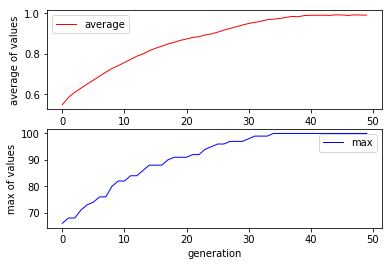

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(2, 1, 1)
plt.xlabel('generation')
plt.ylabel('average of values')
plt.plot(range(n_generation), mean_inds, linewidth=1, color="r", label="average")
plt.legend(loc="best")

plt.subplot(2, 1, 2)
plt.xlabel('generation')
plt.ylabel('max of values')
plt.plot(range(n_generation), max_inds, linewidth=1, color="b", label="max")
plt.legend(loc="best")

plt.show()